# SGD and its variants

We are going to investigate following SGD-family methods:
* Batch Gradient Descent
* Stochastic Gradient Descent
* Mini-Batch Gradient Descent

and several descent techniques including:
* (Naive) Gradient Descent
* Momentum
* SAG: Stochastic Average Gradient

We will also investigate how the following factors affect:
* Data size 
* Data noise level
* Learning rate
* Batch size

Our target problem is Logistic Regression and it's obviously convex. We will use both public dataset and own data simulation using sklearn functions.

## Implementations:

* Logistic Regression (Loss, Gradient, ....)
* Data Preprocessing (Fold split, batch prepartion, ...)
* Descent Methos

In [65]:
import numpy as np
from sklearn.datasets import make_classification
import time
from math import exp
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from random import seed
from random import randrange
from csv import reader
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

X1, y1 = make_classification(n_samples=1000)


In [2]:
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax

def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

filename = 'pima-indians-diabetes.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
X2 = np.array(dataset)[:,:-1]
y2 = np.array(dataset)[:,-1]

In [118]:
sigmoid = lambda z : 1 / (1 + np.exp(-z))
logloss = lambda y_hat, y : np.sum(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)) / len(y_hat)
# logloss = lambda y_hat, y : np.sum(-y * (y_hat) + np.log(1 + np.exp(y_hat))) / len(y_hat)
predict = lambda X: sigmoid(np.dot(X, betas.T)) > .5
predict_with_output = lambda X: (X > .5) * 1


def gradient_descent(X, y, beta, lr):
    y = y.reshape(-1, 1)
    gradients = np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y) / len(y)
    new_betas = beta - lr * gradients.T

    return new_betas, gradients

def momentum_descent(X, y, beta, lr, prev_grad, alpha=0.99):
    y = y.reshape(-1, 1)
    gradients = np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y) / len(y)
    new_betas = beta - lr * gradients.T + alpha * prev_grad.T

    return new_betas, gradients

def saga_descent(X, y, beta, lr, grad, idx):
    y = y.reshape(-1, 1)
    gradients = np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y) / len(y)
    grad[idx] = gradients
    d = np.sum(np.array(grad),axis=0)
    new_betas = beta - (lr / len(grad)) * d.T
    
    return new_betas, grad
    
    

def prepare_batches(X, y, batch_size):
    X_batch_list = list()
    y_batch_list = list()
    
    for i in range(len(y) // batch_size):
        X_batch_list.append(X[i * batch_size : i * batch_size + batch_size, :])
        y_batch_list.append(y[i * batch_size : i * batch_size + batch_size])
    
    if len(y) % batch_size > 0:
        X_batch_list.append(X[len(y) // batch_size * batch_size:, :])
        y_batch_list.append(y[len(y) // batch_size * batch_size:])

    return X_batch_list, y_batch_list

We notice that BGD and SGD are specific Mini-Batch GD with batch size equals to number of smaples in the whole dataset or 1.

In [119]:
def BGD(X_train,y_train,X_test,y_test,lr,batch_size,max_iter,epi=1e-6,patience=2,momentum=False,saga=False,auto_lr=False):
    train_error_hist, test_error_hist, test_acc_hist = MBGD(X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,                                                            
                                                            lr=lr,
                                                            batch_size=X_train.shape[0],
                                                            max_iter=max_iter,
                                                            epi=epi,
                                                            patience=patience,
                                                            momentum=momentum,
                                                            saga=saga,
                                                            auto_lr=auto_lr)
    return train_error_hist, test_error_hist, test_acc_hist


def SGD(X_train,y_train,X_test,y_test,lr,batch_size,max_iter,epi=1e-6,patience=2,momentum=False,saga=False,auto_lr=False):
    train_error_hist, test_error_hist, test_acc_hist = MBGD(X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            lr=lr,
                                                            batch_size=1,
                                                            max_iter=max_iter,
                                                            epi=epi,
                                                            patience=patience,
                                                            momentum=momentum,
                                                            saga=saga,
                                                            auto_lr=auto_lr)
    return train_error_hist, test_error_hist, test_acc_hist

def MBGD(X_train,y_train,X_test,y_test,lr,batch_size,max_iter,epi=1e-6,patience=2,momentum=False,saga=False,auto_lr=False):
    train_error_hist = list()
    test_error_hist = list()
    test_acc_hist = list()

    betas = np.random.random(X_train.shape[1]).reshape(1, -1)

    prev_average = np.inf

    patience_counter = 0
    iteration_counter = 0
    
    if saga:
        grad = list()
        sagaFlag = True
            
    if momentum: 
        grad = np.random.random(X_train.shape[1]).reshape(1, -1).T
    
    while iteration_counter < max_iter:
        if auto_lr:
            lr = 1. / (2*iteration_counter+1.)
        if saga==False:
            X_train, y_train = shuffle(X_train, y_train, random_state=0)
        X_batch_list, y_batch_list = prepare_batches(X_train, y_train, batch_size)
        n_batches = len(y_batch_list)

            
        for i in range(n_batches):
            X_batch = X_batch_list[i]
            y_batch = y_batch_list[i]
            
            if momentum:
                betas, grad = momentum_descent(X_batch, y_batch, betas, lr, grad)
            else:
                if (saga and sagaFlag==False):
                    betas, grad = saga_descent(X_batch, y_batch, betas, lr, grad, i)
                else:
                    betas, gd = gradient_descent(X_batch, y_batch, betas, lr)
                
                if (saga and sagaFlag):
                    grad.append(gd)
                

            y_hat = sigmoid(np.dot(X_batch, betas.T))
            train_error_hist.append(logloss(y_hat, y_batch) / len(y_batch))

            y_hat = sigmoid(np.dot(X_test, betas.T))
            test_error_hist.append(logloss(y_hat, y_test) / len(y_test))
            test_acc_hist.append(np.mean((predict_with_output(y_hat) == y_test.reshape(-1, 1)) * 1))

            iteration_counter += 1

        current_average = np.mean(train_error_hist[-n_batches:])
        
        if saga:
            sagaFlag = False

        if np.abs(prev_average - current_average) < epi:
            patience_counter += 1
        else:
            patience_counter = 0

        prev_average = current_average

        if patience_counter == patience:
            break
    return  train_error_hist, test_error_hist, test_acc_hist


In [120]:
def LR_exp(X,y,split_ratio,method,lr,batch_size=256,max_iter=1000,epi=1e-6,patience=2,momentum=False,saga=False,auto_lr=False):
    permutations = np.random.permutation(len(X))
    X, y = np.asarray(X).squeeze(), np.asarray(y)
    X = X[permutations, :]
    y = y[permutations]
    len_test = len(X) // split_ratio
    len_train = len(X) - len_test
    X_test, y_test, X_train, y_train = X[:len_test, :], y[:len_test], X[len_test:, :], y[len_test:]
    
    train_error_hist, test_error_hist, test_acc_hist = method(X_train,
                                                            y_train,
                                                            X_test,
                                                            y_test,
                                                            lr=lr,
                                                            batch_size=batch_size,
                                                            max_iter=max_iter,
                                                            epi=epi,
                                                            patience=patience,           
                                                            momentum=momentum,
                                                            saga=saga,
                                                            auto_lr=auto_lr)
    plt.figure(figsize=(14,6))
    plt
    plt.subplot(121)
    plt.plot(test_error_hist)
    plt.plot(train_error_hist)
    plt.xlabel("#Iterations")
    plt.ylabel("Total Loss")
    plt.title("Loss VS Iterations")
    plt.legend(("Test", "Train"))
    plt.subplot(122)
    plt.plot(test_acc_hist)
    plt.xlabel("#Iterations")
    plt.ylabel("Accuracy")
    plt.title("Accuracy VS Iterations")
    plt.show()
    

## Result

### Comparsion of BGD, SGD, Mini-BGD

#### Mini-Batch GD

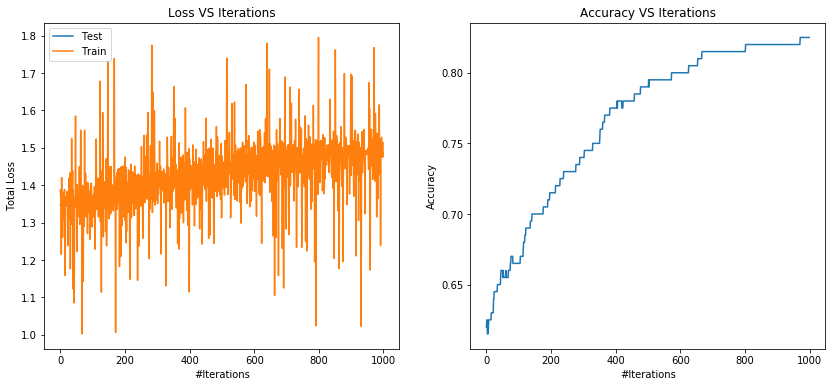

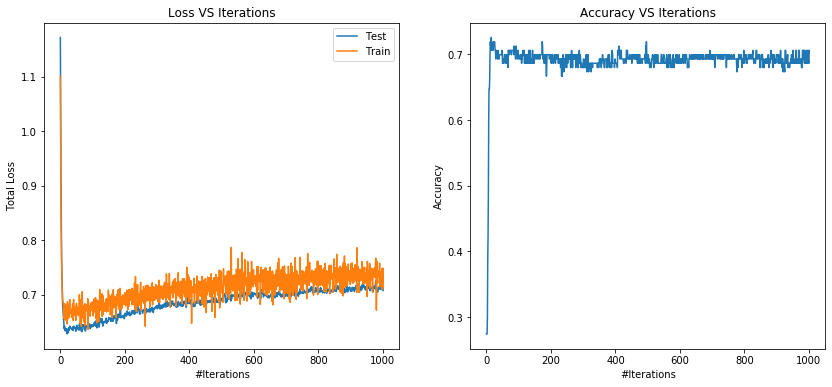

In [121]:
LR_exp(X1,y1,5,MBGD,lr=0.01,batch_size=256)
LR_exp(X2,y2,5,MBGD,lr=0.8,batch_size=256)

#### SGD

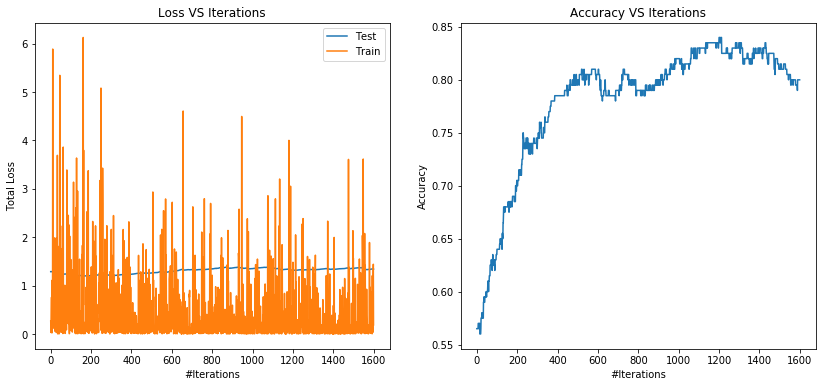

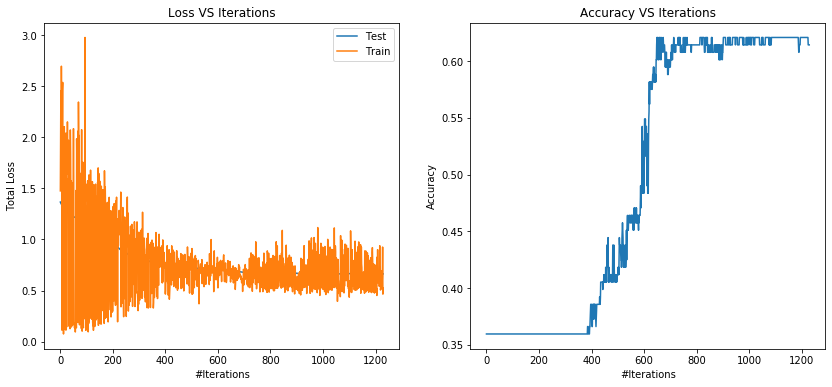

In [122]:
LR_exp(X1,y1,5,SGD,lr=0.01)
LR_exp(X2,y2,5,SGD,lr=0.01)

#### BGD

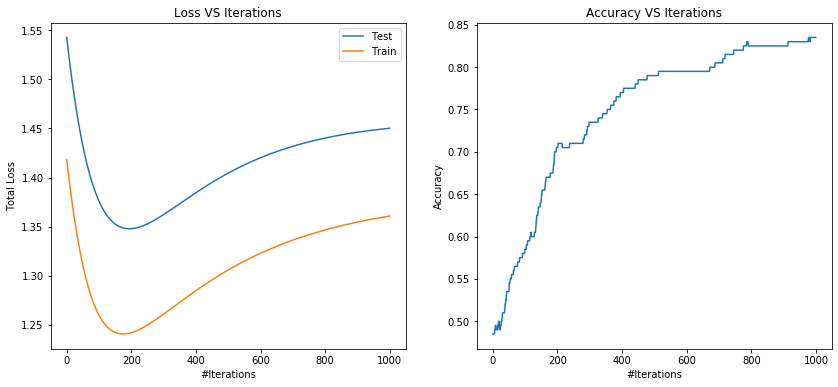

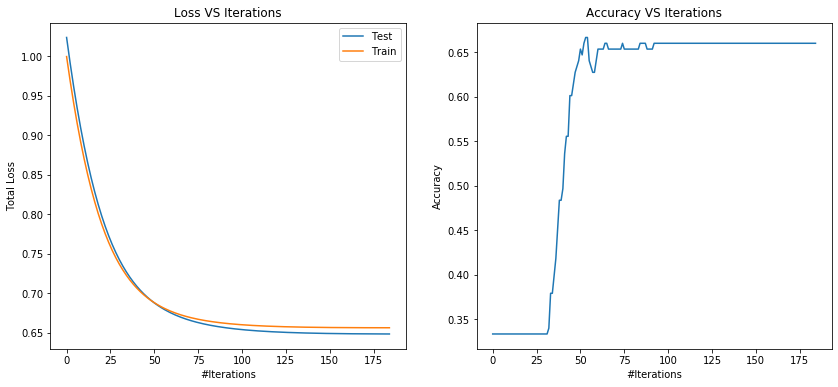

In [123]:
LR_exp(X1,y1,5,BGD,lr=0.01)
LR_exp(X2,y2,5,BGD,lr=0.1)

### Comparison of Momentum, SAG and GD

#### SGD

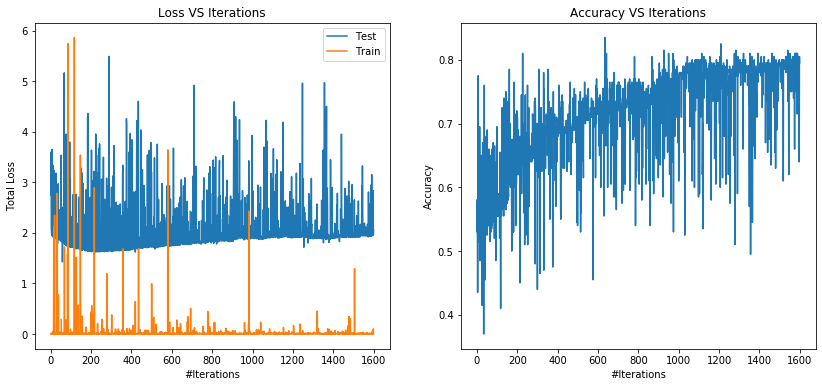

In [124]:
LR_exp(X1,y1,5,SGD,lr=1,momentum=True)

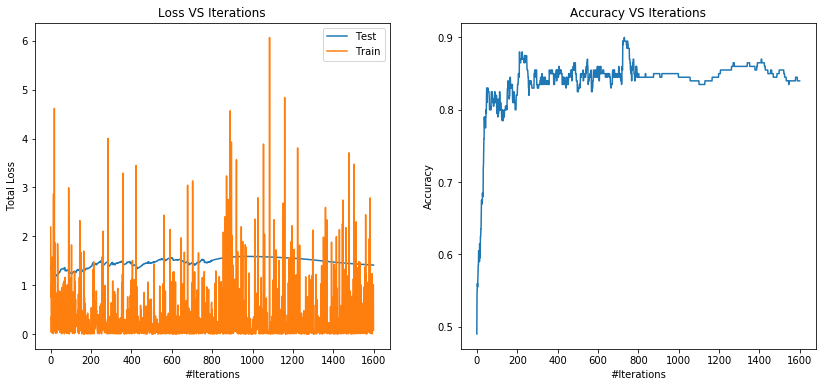

In [125]:
LR_exp(X1,y1,5,SGD,lr=0.05,saga=True)

#### BGD

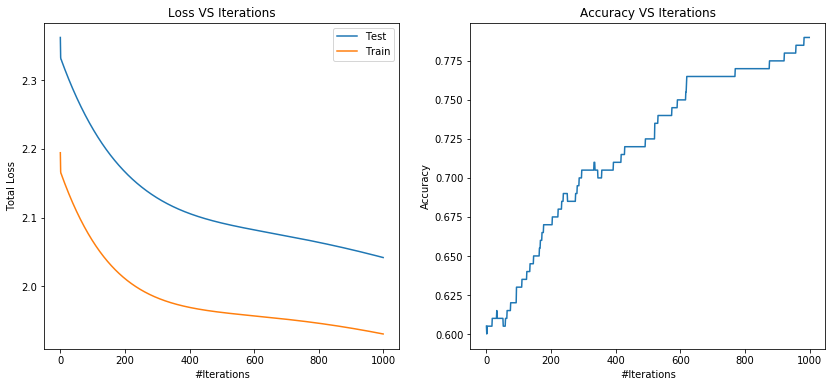

In [126]:
LR_exp(X1,y1,5,BGD,lr=1,momentum=True)

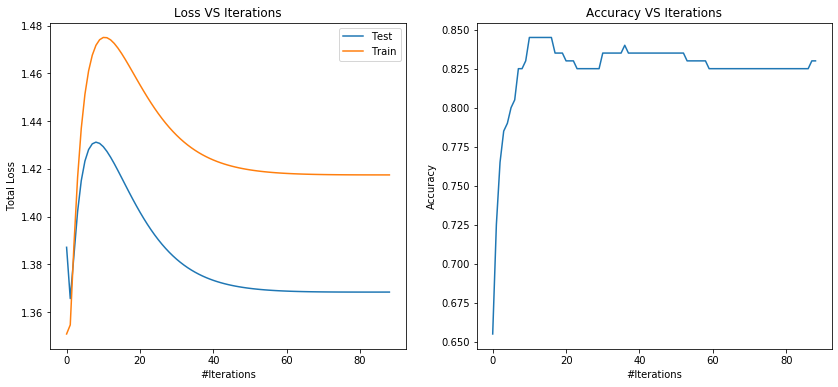

In [127]:
LR_exp(X1,y1,5,BGD,lr=1,saga=True)

### Compare on different Data Noise Level

#### Mini-Batch GD

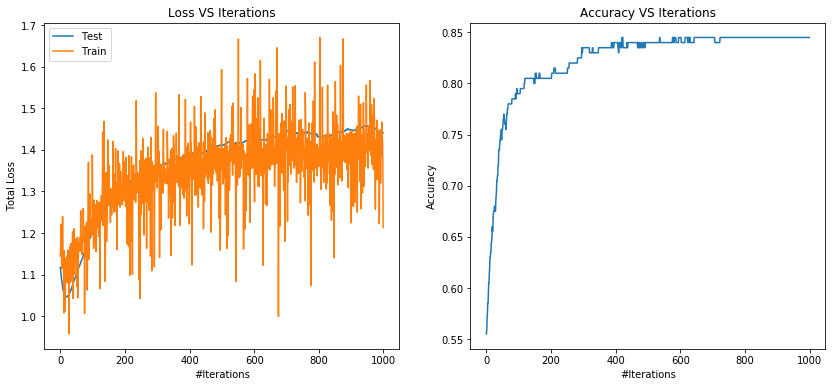

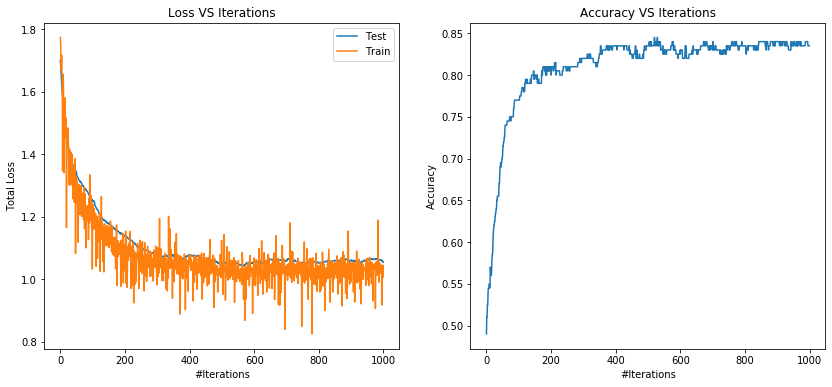

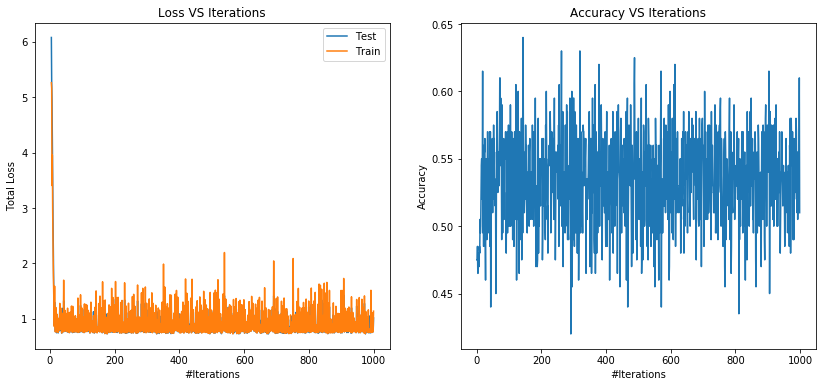

In [128]:
LR_exp(X1,y1,5,MBGD,lr=0.05,batch_size=256)
LR_exp(X1+np.random.randn(*X1.shape),y1,5,MBGD,lr=0.05,batch_size=256)
LR_exp(X1+10*np.random.randn(*X1.shape),y1,5,MBGD,lr=0.05,batch_size=256)

#### SGD

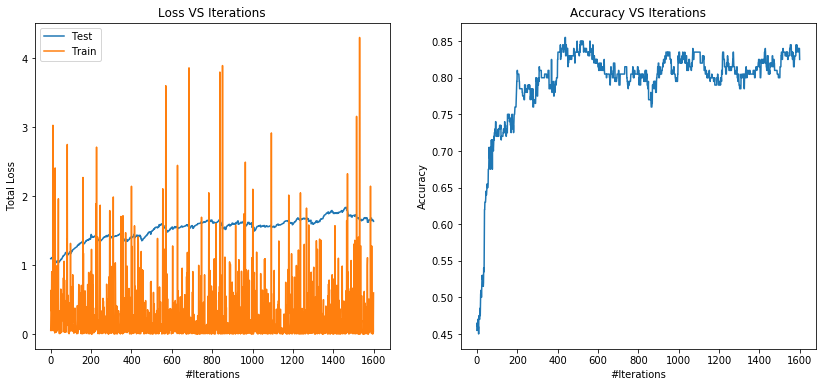

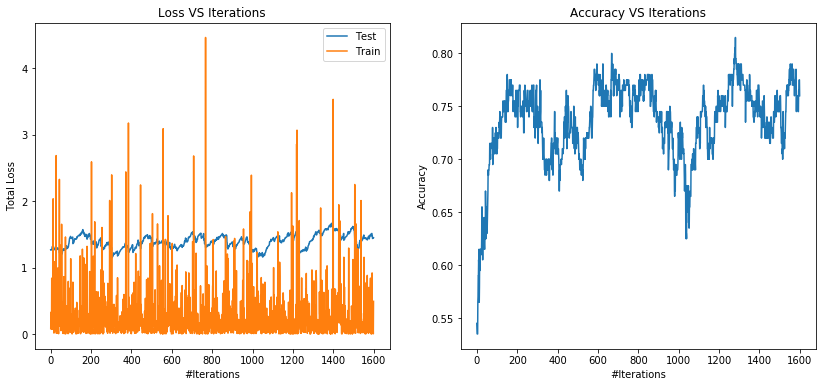

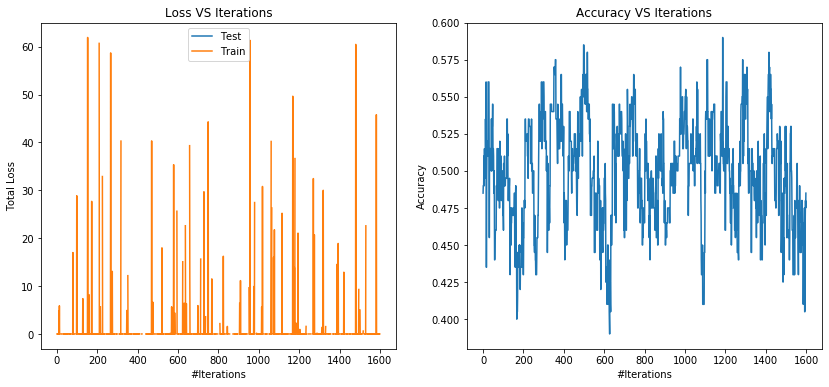

In [129]:
LR_exp(X1,y1,5,SGD,lr=0.05)
LR_exp(X1+np.random.randn(*X1.shape),y1,5,SGD,lr=0.05)
LR_exp(X1+10*np.random.randn(*X1.shape),y1,5,SGD,lr=0.05)

#### BGD

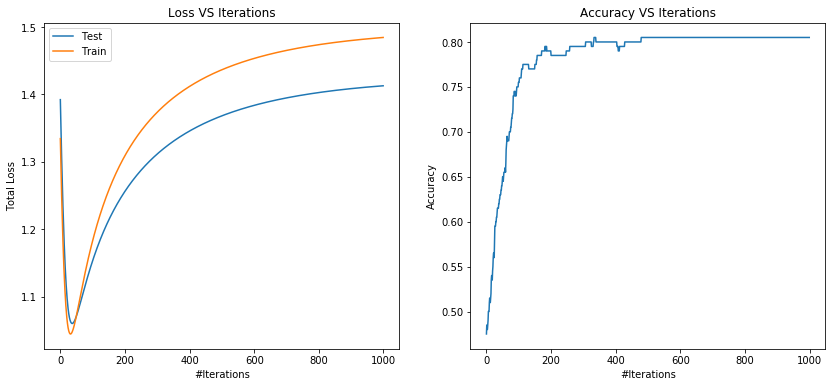

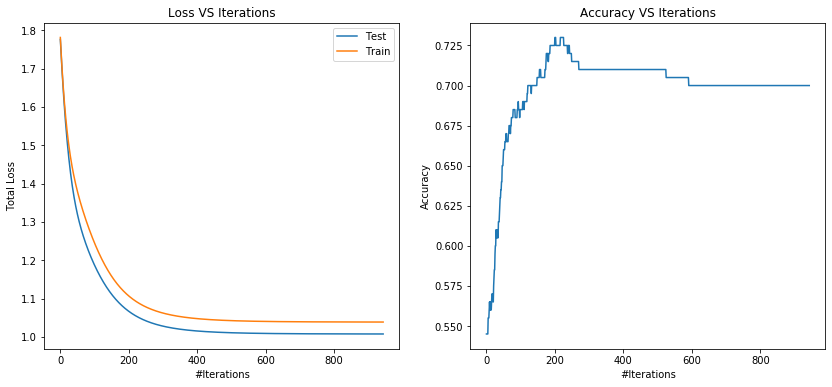

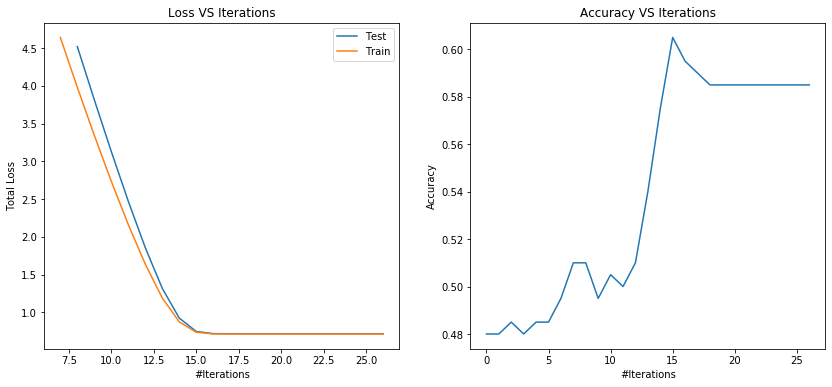

In [130]:
LR_exp(X1,y1,5,BGD,lr=0.05)
LR_exp(X1+np.random.randn(*X1.shape),y1,5,BGD,lr=0.05)
LR_exp(X1+10*np.random.randn(*X1.shape),y1,5,BGD,lr=0.05)

### Comparsion of different learning rate choices

#### Mini-GD

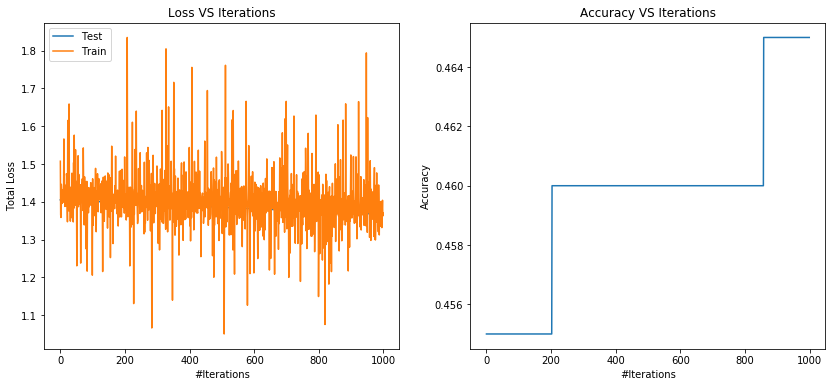

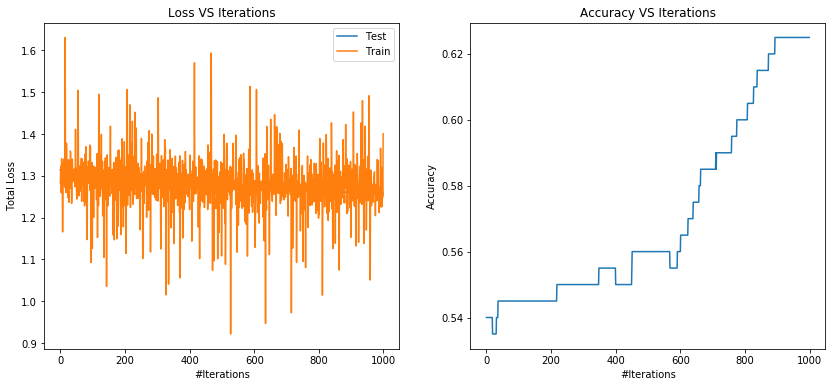

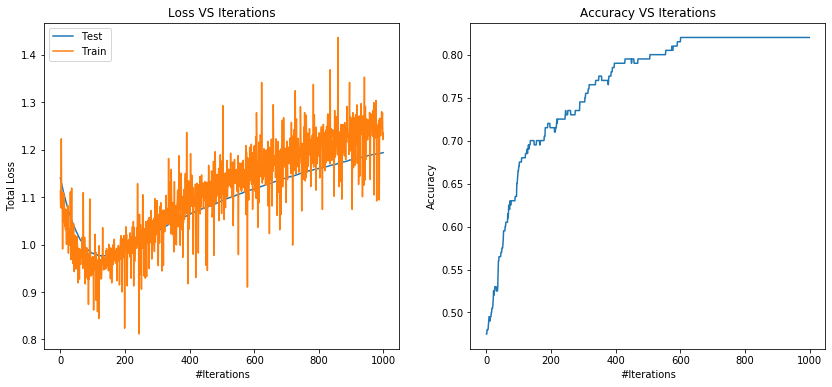

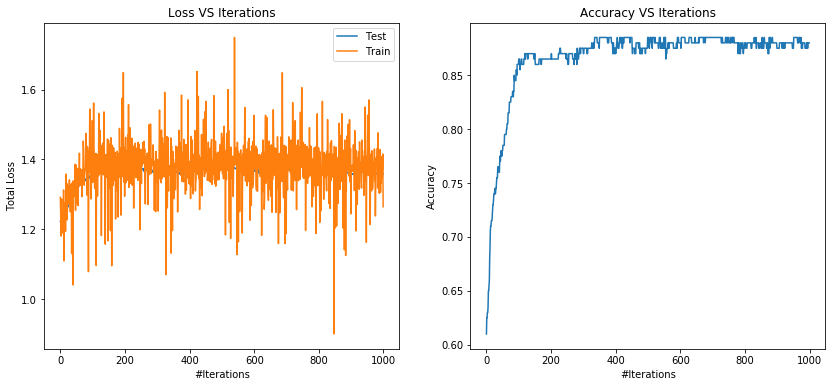

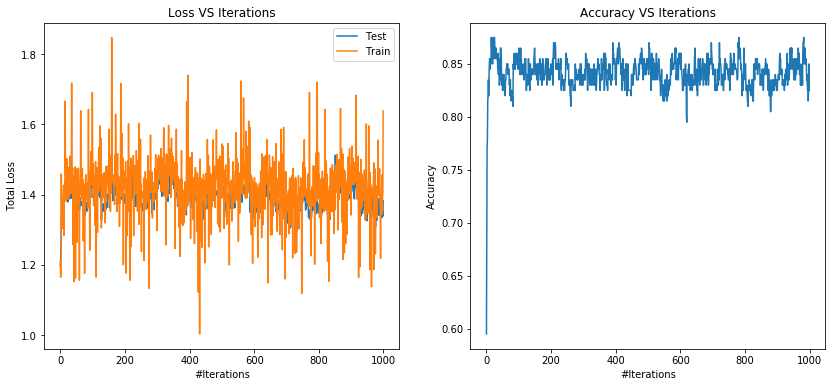

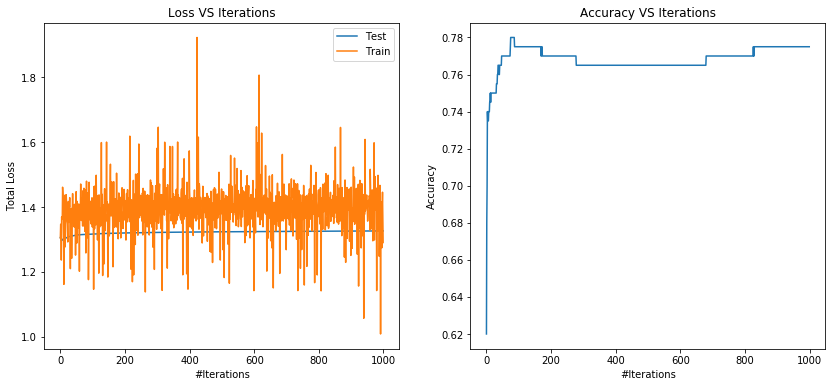

In [145]:
LR_exp(X1,y1,5,MBGD,lr=1e-4,batch_size=256)
LR_exp(X1,y1,5,MBGD,lr=1e-3,batch_size=256)
LR_exp(X1,y1,5,MBGD,lr=1e-2,batch_size=256)
LR_exp(X1,y1,5,MBGD,lr=1e-1,batch_size=256)
LR_exp(X1,y1,5,MBGD,lr=1,batch_size=256)
LR_exp(X1,y1,5,MBGD,lr=1,auto_lr=True)

#### SGD

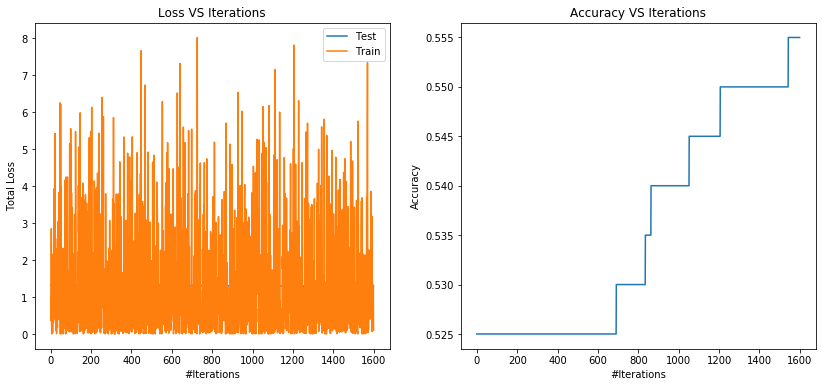

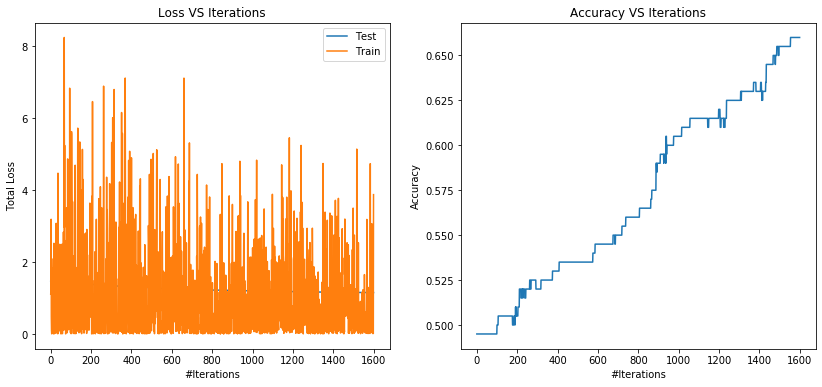

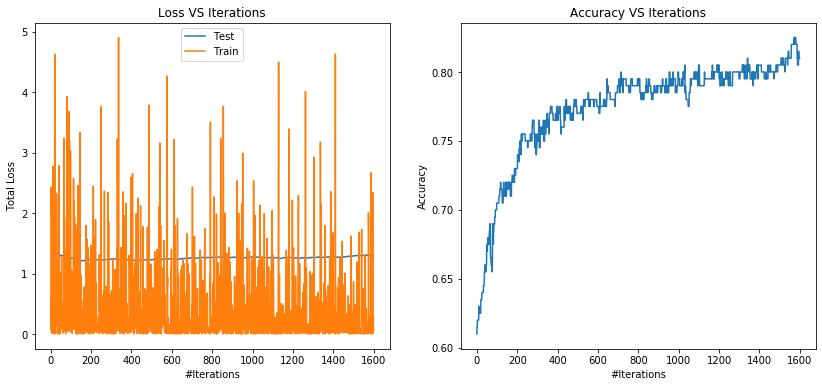

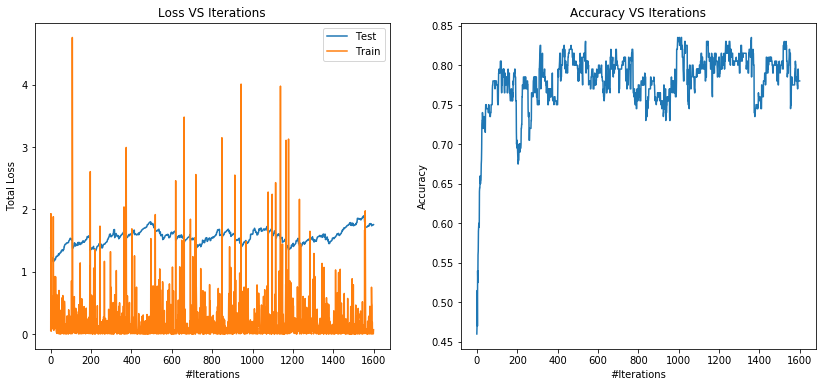

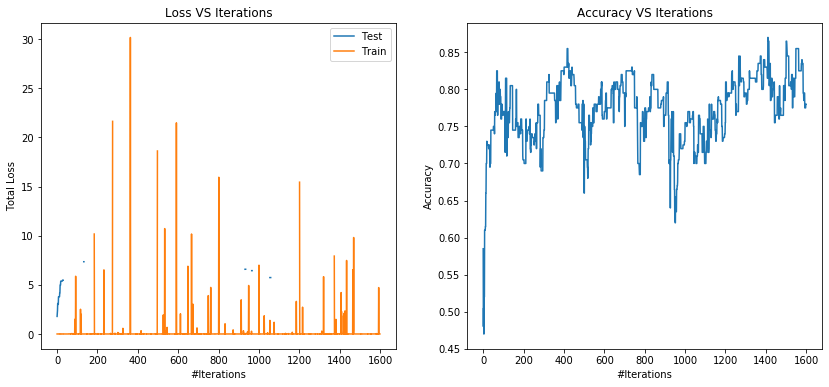

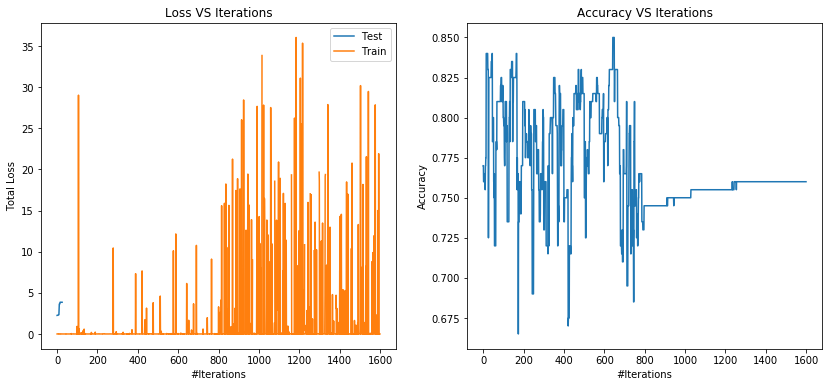

In [144]:
LR_exp(X1,y1,5,SGD,lr=1e-4)
LR_exp(X1,y1,5,SGD,lr=1e-3)
LR_exp(X1,y1,5,SGD,lr=1e-2)
LR_exp(X1,y1,5,SGD,lr=1e-1)
LR_exp(X1,y1,5,SGD,lr=1)
LR_exp(X1,y1,5,SGD,lr=1,auto_lr=True)

#### BGD

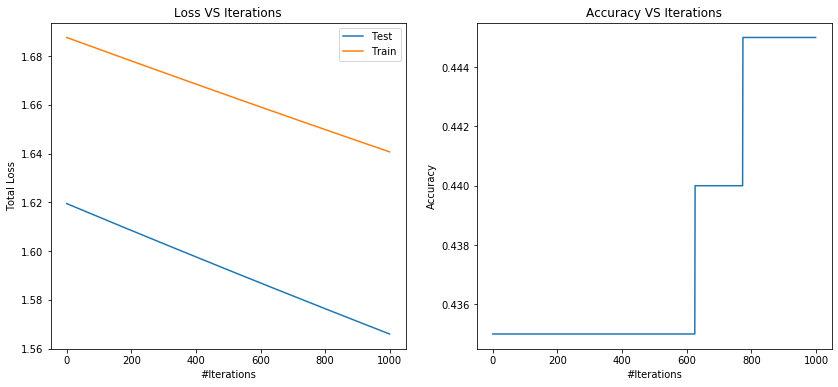

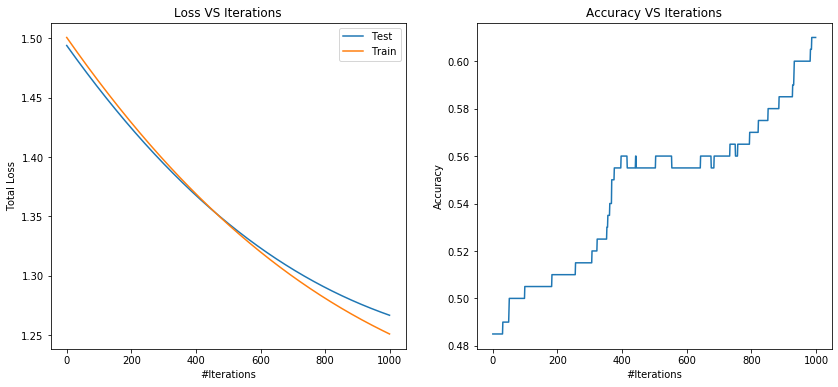

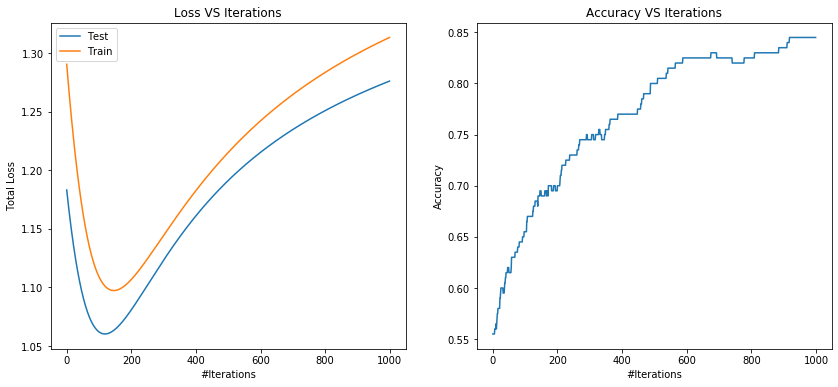

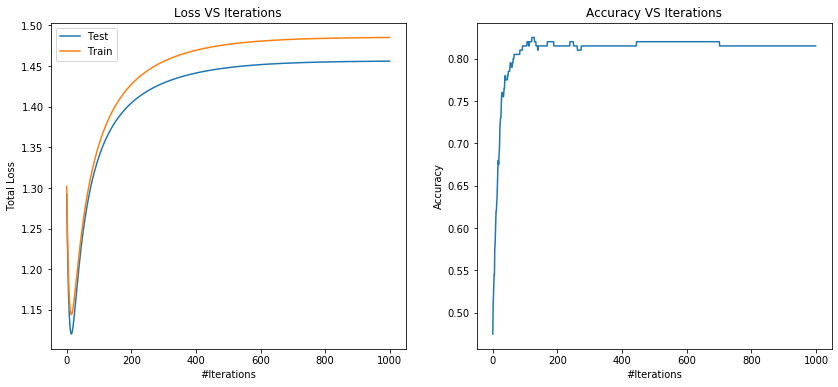

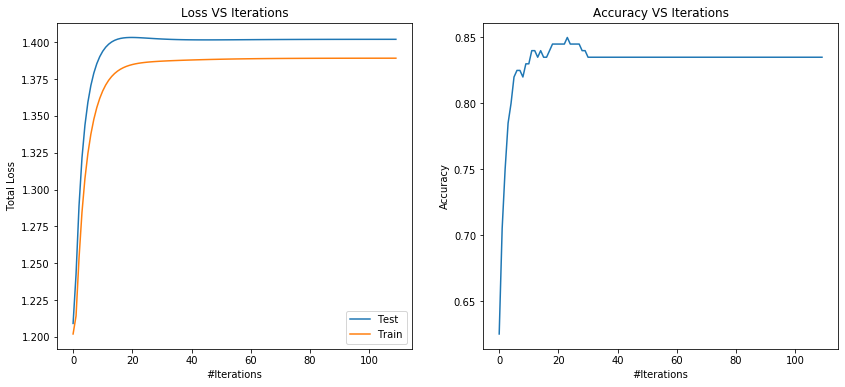

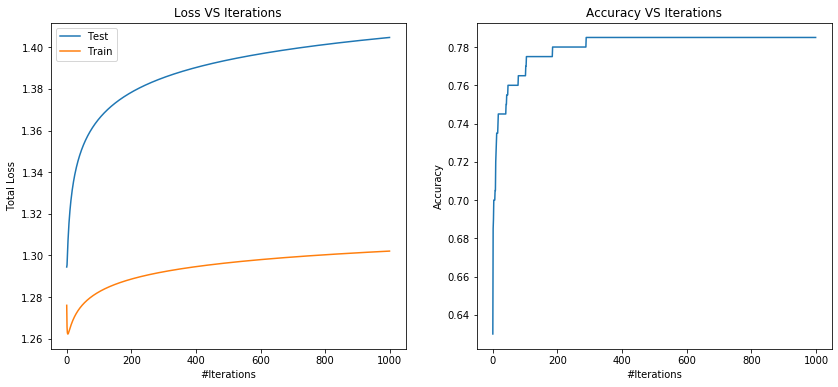

In [146]:
LR_exp(X1,y1,5,BGD,lr=1e-4)
LR_exp(X1,y1,5,BGD,lr=1e-3)
LR_exp(X1,y1,5,BGD,lr=1e-2)
LR_exp(X1,y1,5,BGD,lr=1e-1)
LR_exp(X1,y1,5,BGD,lr=1)
LR_exp(X1,y1,5,BGD,lr=1,auto_lr=True)

### Comparsion of different batch size 

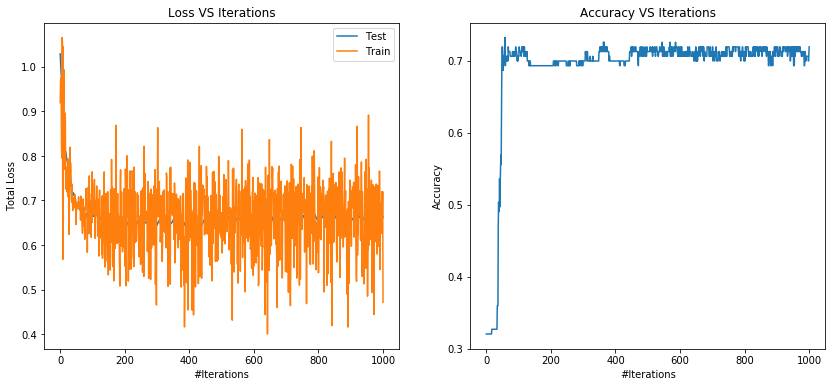

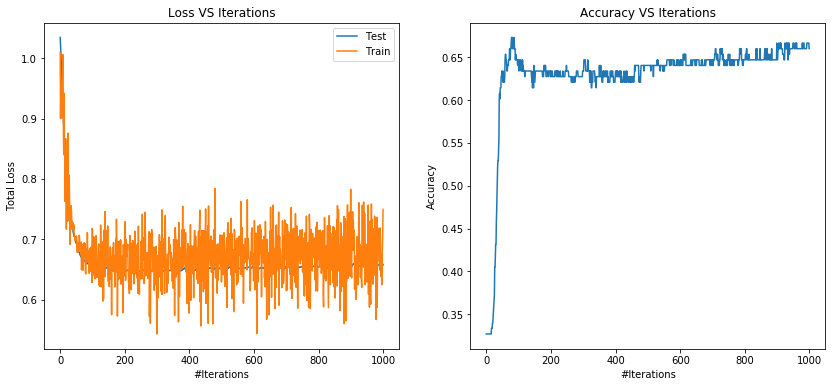

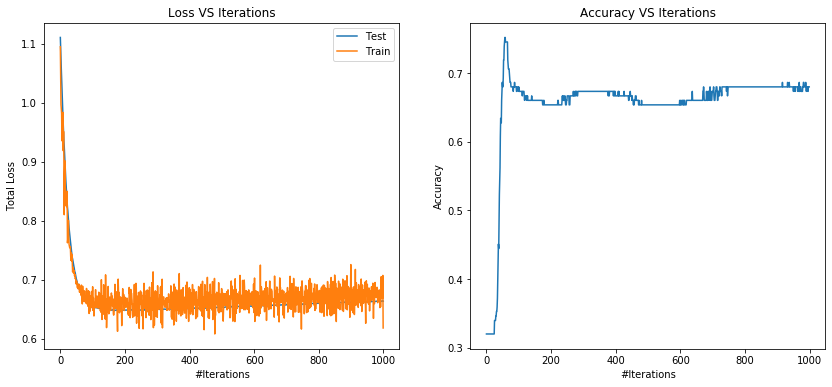

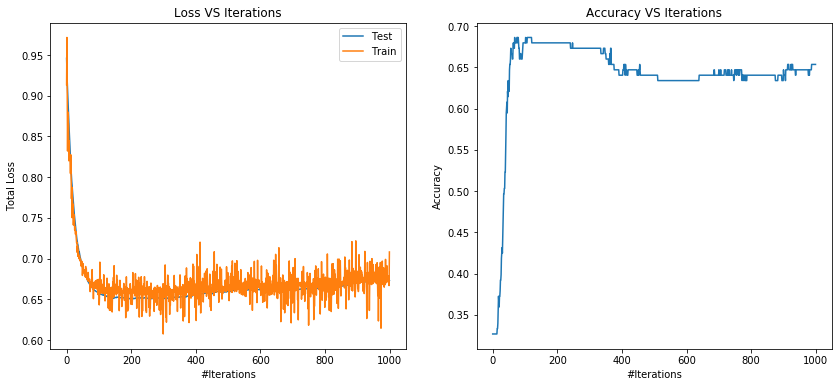

In [138]:
lr = 0.1
LR_exp(X2,y2,5,MBGD,lr=lr,batch_size=8)
LR_exp(X2,y2,5,MBGD,lr=lr,batch_size=32)
LR_exp(X2,y2,5,MBGD,lr=lr,batch_size=128)
LR_exp(X2,y2,5,MBGD,lr=lr,batch_size=512)

## Conclusion

* Differences in BGD, SGD and Mini-Batch GD are mainly result from batch size different; larger batch size will lead to more stable training process but has little effect on final accuracy. When applying SGD, we should choose batch size according to how much memory we have.

* Momentum can acclerate optimization and help prevent stucking at the local minima. However for our problem, there is no local minima and we can only see the accleration.

* SAG adds certainty to randomness, similar to the role of mini-batch sgd. However, SAG only uses the gradients calculated previously, so the calculation cost per iteration is much less than mini-batch SGD, which is equivalent to SGD. Therefore, SAG converges much faster than SAG　and reduce variance.

* Proper noise will not harm the performance obviously but large noise will ruin everything. BGD is the most robust method when facing noisy data.

* Learning rate changes have a strong impact on the training process. Small steps will lead to underfitting and large steps may cause overfitting.